In [127]:
import pandas as pd
import numpy as np
import names
import datetime
import seaborn as sns
import matplotlib.pyplot as plt


## Simulate slack data

The data similar to simulated data here can be pulled regularly via API from an org's slack data. I'll look at fake individual's account data in this notebook, though there also exists day-by-day aggregate data across the entire organization (% of messages sent in public channels vs private channels, etc). This info is publicly available by default to all members in a particular organization via Tools > Analytics (https://slack.com/help/articles/218407447-View-your-Slack-analytics-dashboard). There is an analytics API available exclusively for the admins in slack: https://api.slack.com/methods/admin.analytics.getFile. 

In [28]:
# will create n dataframes of fake slack date, each corresponding to a 1-week range of time export from the Slack analytics page

# function to grabe month, date, year from n weeks ago
def get_date_n_weeks_ago(n):
    return (pd.Timestamp.now() - pd.DateOffset(weeks=n)).strftime("%m_%d_%Y")


In [29]:
get_date_n_weeks_ago(1)

'01_14_2023'

In [30]:
n_weeks = 10

for i in range(0, n_weeks):
    print(get_date_n_weeks_ago(i))

01_21_2023
01_14_2023
01_07_2023
12_31_2022
12_24_2022
12_17_2022
12_10_2022
12_03_2022
11_26_2022
11_19_2022


Define functions to make fake dataframe for each week - these are the cols in the Slack Analytics output
Person
Department
Acct Created
Days Active
Messages Sent

In [159]:
#the following 3 could also be a dict, but laying out for clarity 
departments = ['Marketing', 'Sales', 'Engineering', 'Product', 'Design', 'Customer Success', 'Finance', 'People', 'Legal', 'Other']
department_assignment_probs = [0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05] #sum to 1
department_prob_active = [0.8, 0.5, 0.6, 0.8, 0.9, 0.9, 0.9, 0.7, 0.9, 0.9] # probability someone in a particular dept is active on a given day
messages_per_day = 3 #messages if active

acct_created = pd.Timestamp(2019, 1, 1)
names_list = [names.get_full_name() for i in range(100)]

def make_init_data_frame(num_employees):
    data_dict = {}
    for i in range(num_employees):
        person = names.get_full_name()
        department_ind = np.random.choice(len(departments), p=department_assignment_probs)
        department = departments[department_ind]
        days_active = np.random.binomial(5, department_prob_active[department_ind]) #modeling days active as a binomial distribution
        messages_sent = np.random.poisson(days_active*messages_per_day) #modeling messages sent as a poisson distribution with lambda = days_active*messages_per_day
        creation_date = acct_created
        data_dict[person] = [department, days_active, messages_sent, creation_date]
    df = pd.DataFrame.from_dict(data_dict, orient='index', columns=['department', 'days_active', 'messages_sent', 'acct_creation_date'])
    return df




def get_prob_activity_given_week(week_num):
    #add slack disengagement in first half of departments with time passage
    #add slack engagement in 2nd half of departments with time passage
    # return prob_active for a given week
    # this is unrealistic but just for fun
    prob_active_week = []
    for i in range(len(department_prob_active)):
        if i < len(department_prob_active)/2:
            new_active  = max(0,department_prob_active[i] - week_num*abs(np.random.normal(0, 0.05)))
            prob_active_week.append(new_active)
        else:
            new_active = min(1, department_prob_active[i] + week_num*abs(np.random.normal(0, 0.05)))
            prob_active_week.append(new_active)
    return prob_active_week
        
    






In [160]:
def make_longform_data_frame(num_employees, num_weeks):
    data_dict = {}
    for i in range(num_employees):
        person = names.get_full_name()
        department_ind = np.random.choice(len(departments), p=department_assignment_probs)
        department = departments[department_ind]
        week_k_days_active = []
        week_k_messages_sent = []
        for k in range(num_weeks):
            prob_active_week_k = get_prob_activity_given_week(k)
            days_active = np.random.binomial(5, prob_active_week_k[department_ind]) #modeling days active as a binomial distribution
            messages_sent = np.random.poisson(days_active*messages_per_day) #modeling messages sent as a poisson distribution with lambda = days_active*messages_per_day
            week_k_days_active.append(days_active)
            week_k_messages_sent.append(messages_sent)
            
        data_dict[person] = [department, week_k_days_active, week_k_messages_sent, ]
    df = pd.DataFrame.from_dict(data_dict, orient='index', columns=['department', 'days_active', 'messages_sent'])
    return df


In [161]:
n_weeks = 10
num_employees = 100
employee_engagement = make_longform_data_frame(num_employees, n_weeks)

In [162]:
employee_engagement.head(5)

,department,days_active,messages_sent
Alex Koester,Engineering,"[5, 3, 2, 3, 2, 1, 3, 3, 2, 0]","[18, 13, 2, 10, 5, 5, 12, 10, 7, 0]"
Barbara Willis,Customer Success,"[5, 4, 5, 5, 5, 5, 5, 5, 5, 5]","[15, 12, 14, 17, 12, 14, 13, 15, 16, 14]"
Delores Dana,Customer Success,"[5, 5, 5, 4, 5, 5, 4, 5, 5, 5]","[13, 21, 20, 14, 22, 18, 11, 13, 22, 15]"
Mark Puotinen,Marketing,"[3, 5, 2, 5, 3, 3, 4, 4, 4, 3]","[11, 11, 7, 12, 11, 9, 19, 13, 9, 6]"
Martha Bandy,Engineering,"[2, 4, 1, 0, 3, 0, 2, 1, 4, 2]","[7, 17, 2, 0, 8, 0, 10, 2, 11, 3]"


In [163]:
week_labels = [get_date_n_weeks_ago(i) for i in range(n_weeks)]

In [164]:
longform_days_active = pd.DataFrame(employee_engagement['days_active'].tolist(), index=employee_engagement.index, columns=[f'days_engaged_{w}' for w in week_labels])

In [165]:
longform_days_active

,days_engaged_01_21_2023,days_engaged_01_14_2023,days_engaged_01_07_2023,days_engaged_12_31_2022,days_engaged_12_24_2022,days_engaged_12_17_2022,days_engaged_12_10_2022,days_engaged_12_03_2022,days_engaged_11_26_2022,days_engaged_11_19_2022
Alex Koester,5,3,2,3,2,1,3,3,2,0
Barbara Willis,5,4,5,5,5,5,5,5,5,5
Delores Dana,5,5,5,4,5,5,4,5,5,5
Mark Puotinen,3,5,2,5,3,3,4,4,4,3
Martha Bandy,2,4,1,0,3,0,2,1,4,2
...,...,...,...,...,...,...,...,...,...,...
Lynne Wackman,4,5,2,5,3,1,3,1,4,0
Darrell Jourdan,4,4,3,3,0,1,2,0,3,0
Patricia Cabral,5,4,5,5,5,5,5,5,5,5
Donald Pierce,5,5,5,5,5,5,5,5,5,5


In [166]:
longform_messages_sent = pd.DataFrame(employee_engagement['messages_sent'].tolist(), index=employee_engagement.index, columns=[f'm_{w}' for w in week_labels])

In [167]:
longform_messages_sent

,m_01_21_2023,m_01_14_2023,m_01_07_2023,m_12_31_2022,m_12_24_2022,m_12_17_2022,m_12_10_2022,m_12_03_2022,m_11_26_2022,m_11_19_2022
Alex Koester,18,13,2,10,5,5,12,10,7,0
Barbara Willis,15,12,14,17,12,14,13,15,16,14
Delores Dana,13,21,20,14,22,18,11,13,22,15
Mark Puotinen,11,11,7,12,11,9,19,13,9,6
Martha Bandy,7,17,2,0,8,0,10,2,11,3
...,...,...,...,...,...,...,...,...,...,...
Lynne Wackman,14,12,10,16,9,1,7,1,16,0
Darrell Jourdan,12,9,11,3,0,3,10,0,9,0
Patricia Cabral,17,10,22,11,17,14,8,19,15,20
Donald Pierce,18,13,8,21,12,20,15,21,5,18


In [168]:
messages_agg = pd.concat([employee_engagement, longform_messages_sent], axis=1)

In [169]:
messages_agg.groupby('department').agg('mean')

/var/folders/jj/sp3x8cp572sdmhwd0ytnzn2r0000gn/T/ipykernel_91517/889020439.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  messages_agg.groupby('department').agg('mean')


,m_01_21_2023,m_01_14_2023,m_01_07_2023,m_12_31_2022,m_12_24_2022,m_12_17_2022,m_12_10_2022,m_12_03_2022,m_11_26_2022,m_11_19_2022
department,,,,,,,,,,
Customer Success,14.312500,13.375000,12.875000,13.812500,13.062500,13.687500,14.375000,14.750000,13.687500,15.812500
Design,12.090909,16.090909,12.727273,11.818182,12.090909,10.636364,9.545455,8.363636,6.909091,8.363636
Engineering,8.538462,10.961538,7.653846,5.961538,5.269231,4.192308,5.423077,5.576923,5.500000,4.307692
Finance,14.428571,14.142857,11.428571,17.142857,14.000000,16.428571,13.571429,13.142857,13.571429,15.428571
Legal,10.000000,19.000000,14.500000,12.500000,10.500000,19.000000,18.500000,13.000000,15.000000,15.500000
Marketing,10.454545,13.454545,9.454545,9.727273,11.272727,9.545455,10.090909,10.181818,7.272727,5.545455
Other,14.600000,11.600000,13.800000,15.000000,11.400000,13.400000,11.400000,14.600000,10.400000,16.800000
People,12.600000,14.600000,10.400000,13.000000,11.600000,12.000000,12.600000,13.800000,14.200000,13.000000
Product,12.833333,9.833333,8.333333,11.166667,8.000000,10.000000,6.666667,9.333333,5.500000,5.666667


In [170]:
aggregate = messages_agg.groupby('department').agg('mean', numeric_only=True)


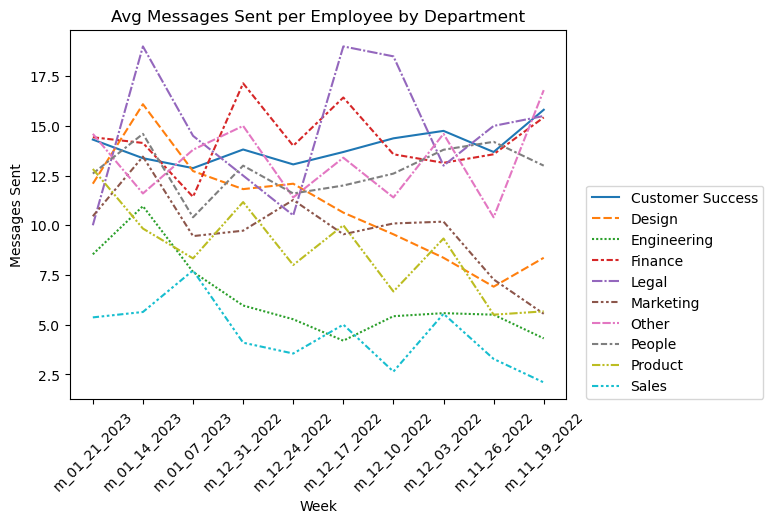

In [173]:
sns.lineplot(data =  aggregate.T)
plt.xticks(rotation=45)
plt.ylabel('Messages Sent (per capita')
plt.xlabel('Week')
plt.title('Avg Messages Sent Department')

plt.legend(loc=(1.04, 0))
